# Multilabel classification on PASCAL using python data-layers

In this tutorial we will do multilabel classification on PASCAL VOC 2012. 

Caffe supports multi-label classification through the SigmoidCrossEntropyLoss, and we will load data using a python data-layer. Data could also be provided through a HDF5 data-layer, but the python data-layer provide endless flexibility, so that's what we will use.

### Preliminaries

First, make sure you compile caffe using 
WITH_PYTHON_LAYER ;= 1

Second, download PASCAL VOC 2012. It's available here: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html

Third, set paths and import modules:

In [1]:
# set root directory, e.g:
pascal_root = '/data/pascal/VOC2012'

# import some modules
import sys, os, caffe
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.append("pycaffe/layers") # the datalayers we will use are in this directory.
sys.path.append("pycaffe") # the tools file is in this folder

import tools #this contains some tools that we need

# make sure we have the caffenet weight downloaded.
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

# initialize caffe for gpu mode
caffe.set_mode_gpu()
caffe.set_device(0)

Let's start by defining the nets using caffe.NetSpec. Note how we used the SigmoidCrossEntropyLoss layer. This is the right loss for multilabel classification. Also note how the data layer is defined.

In [2]:
from caffe import layers as L, params as P, to_proto
from caffe.proto import caffe_pb2

# helper function for common structures
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

# another helper function
def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

# yet another helper function
def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

# main netspec wrapper
def caffenet_multilabel(data_layer_params, datalayer):
    # setup the python data layer 
    n = caffe.NetSpec()
    n.data, n.label = L.Python(module = 'pascal_multilabel_datalayers', layer = datalayer, 
                               ntop = 2, param_str=str(data_layer_params))

    # the net itself
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    n.score = L.InnerProduct(n.drop7, num_output=20)
    n.loss = L.SigmoidCrossEntropyLoss(n.score, n.label)
    
    return str(n.to_proto())

Now we can crete net and solver prototxts. For the solver, we use the CaffeSolver class from the "tools" module

In [4]:
workdir = './pascal_multilabel_with_datalayer'
os.makedirs(workdir)
solverprototxt = tools.CaffeSolver(trainnet_prototxt_path = osp.join(workdir, "trainnet.prototxt"), testnet_prototxt_path = osp.join(workdir, "valnet.prototxt"))
solverprototxt.sp['display'] = "1"
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.write(osp.join(workdir, 'solver.prototxt'))

# write train and val nets.
with open(osp.join(workdir, 'trainnet.prototxt'), 'w') as f:
    # provide parameters to the data layer as a python dictionary. Easy as pie!
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'train', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerSync'))

with open(osp.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'val', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerSync'))

This net uses a python datalayer: PascalMultilabelDataLayerSync, which is defined in ./pycaffe/layers/pascal_multilabel_datalayers.py. Take a look at the codel. It's quite straight-forward, and gives you full control over data and labels.


Now we can load the caffe solver as usual.

In [5]:
solver = caffe.SGDSolver(osp.join(workdir, 'solver.prototxt'))
solver.net.copy_from(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)
solver.step(1)

PascalMultilabelDataLayerSync initialized for split: train, with bs:128, im_shape:[227, 227], and 5717 images.
PascalMultilabelDataLayerSync initialized for split: val, with bs:128, im_shape:[227, 227], and 5823 images.


Let's check the data we have loaded.

Ground truth:  horse, person,


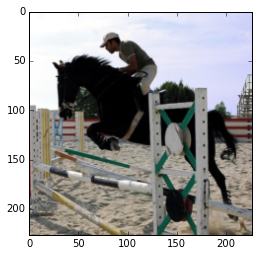

In [6]:
% matplotlib inline
from pascal_multilabel_with_datalayer_tools import SimpleTransformer
from copy import copy
transformer = SimpleTransformer() # this is simply to add back the bias, re-shuffle the color channels to RGB, and so on...

image_index = 0 #Lets look at the first image in the batch.
plt.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
print 'Ground truth: ',
for idx, val in enumerate(gtlist):
    if val:
        print classes[idx] + ',',



Alright. So far so good. We now have a working python datalayer that we can customize to our needs, e.g. by adding more data-augmentation or modify for other data-sets or tasks. Next, we will look at how to make it more efficient. The PascalMultilabelDataLayerSync loads the data syncronously, meaning that the GPU sits idle while the CPU loads the data. Fortunately, some simple multi-threading solves this problem. Let's do that next. First, though, lets measure the step time of this syncronous layer. 

In [12]:
%%time
solver.step(10)

CPU times: user 13.9 s, sys: 363 ms, total: 14.2 s
Wall time: 14.2 s


Now, let's setup solvers and nets with the PascalMultilabelDataLayerAsync layer. Take a look at the code in ./pycaffe/layers/pascal_multilabel_datalayers.py, it's not hard.

In [7]:
workdir = './pascal_multilabel_with_datalayer'
solverprototxt = tools.CaffeSolver(trainnet_prototxt_path = osp.join(workdir, "trainnet_async.prototxt"), testnet_prototxt_path = osp.join(workdir, "valnet_async.prototxt"))
solverprototxt.sp['display'] = "1"
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.write(osp.join(workdir, 'solver_async.prototxt'))

# write train and val nets.
with open(osp.join(workdir, 'trainnet_async.prototxt'), 'w') as f:
    # provide parameters to the data layer as a python dictionary. Easy as pie!
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'train', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerAsync'))

with open(osp.join(workdir, 'valnet_async.prototxt'), 'w') as f:
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'val', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerAsync'))

solver_async = caffe.SGDSolver(osp.join(workdir, 'solver_async.prototxt'))
solver_async.net.copy_from(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
solver_async.test_nets[0].share_with(solver_async.net)
solver_async.step(1)


BatchAdvancer initialized with 5717 images
PascalMultilabelDataLayerAsync initialized for split: train, with bs:128, im_shape:[227, 227].
BatchAdvancer initialized with 5823 images
PascalMultilabelDataLayerAsync initialized for split: val, with bs:128, im_shape:[227, 227].


Check runtime ...

In [8]:
%%time
solver_async.step(10)

CPU times: user 15.7 s, sys: 476 ms, total: 16.1 s
Wall time: 16 s


Alright, that is a modest runtime gain. However, as you data pre-processing becomes more complicated, this difference will increase.

Let's train the net for a while. First, though, we need some way to measure the accuracy. Hamming distance is commonly used in multilabel problems. We also need a simple test loop. Let's write that down. 

In [8]:
def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e]) / float(len(gt))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

Alright, let's train.

In [10]:
for itt in range(500):
    solver_async.step(1)
    if itt % 100 == 0:
        print 'itt:{}'.format(itt), 'accuracy:{0:.4f}'.format(check_accuracy(solver_async.test_nets[0], 10))

itt:0 accuracy:0.9430
itt:100 accuracy:0.9511
itt:200 accuracy:0.9573
itt:300 accuracy:0.9600
itt:400 accuracy:0.9583


Great, accuracy is increasing, and it seems to converge rather quickly. It may seem strange that it starts off so high but it is because the ground truth is sparse. There are 20 classes in PASCAL, and usually only one or two is present. So predicting all zeros yields rather high accuracy. Let's check to make sure.

In [11]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, 20))
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print 'Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver_async.test_nets[0], 5823/128))

Baseline accuracy:0.9243


Let's wrap this up by looking at some qualitative results

Ground truth:  bird, 
Estimated:  bird,


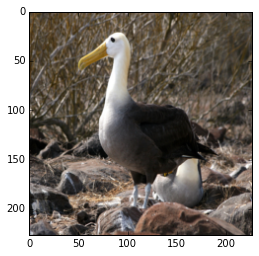

In [12]:
% matplotlib inline
from pascal_multilabel_with_datalayer_tutorial_tools import SimpleTransformer
from copy import copy
transformer = SimpleTransformer() # this is simply to add back the bias, re-shuffle the color channels to RGB, and so on...

image_index = 0 #Lets look at the first image in the batch.
test_net = solver_async.test_nets[0]
test_net.forward()
plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
estlist = test_net.blobs['score'].data[image_index, ...] > 0
classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
print 'Ground truth: ',
for idx, val in enumerate(gtlist):
    if val:
        print classes[idx] + ',',

print ''  
print 'Estimated: ',
for idx, val in enumerate(estlist):
    if val == 1:
        print classes[idx] + ',',